In [9]:
import  os
import matplotlib.pyplot as plt
import SimpleITK as sitk
import torch
import numpy as np
import nibabel as nib
datadir = "/home/dell/data/Dataset/Brats21/DATASET/nnUNet_trained_models/nnUNet/3d_fullres/Task043_BraTS21/CalibflipUNetTrainerV5MaskLabel__nnUNetPlansv2.1/fold_5/flip_matrix/epoch98"


In [10]:
full_list = os.listdir(datadir) 
matrix_list = []
for names in full_list:
    if names.endswith("nii.gz"):
        matrix_list.append(names)
print(matrix_list)

['image3.nii.gz', 'target.nii.gz', 'image2.nii.gz', 'image0.nii.gz', 'image1.nii.gz', 'mask_label.nii.gz']


In [11]:
# pathes to matries
#for i in range
image_dir = os.path.join(datadir,'image0.nii.gz')
image=nib.load(image_dir).get_fdata()
print(image.shape)
target_dir = os.path.join(datadir,'target.nii.gz')
target=nib.load(target_dir).get_fdata()
print(target.shape)
flip_dir = os.path.join(datadir,'mask_label.nii.gz')
flip=nib.load(flip_dir).get_fdata()
print(flip.shape)

(96, 96, 96)
(96, 96, 96)
(96, 96, 96)


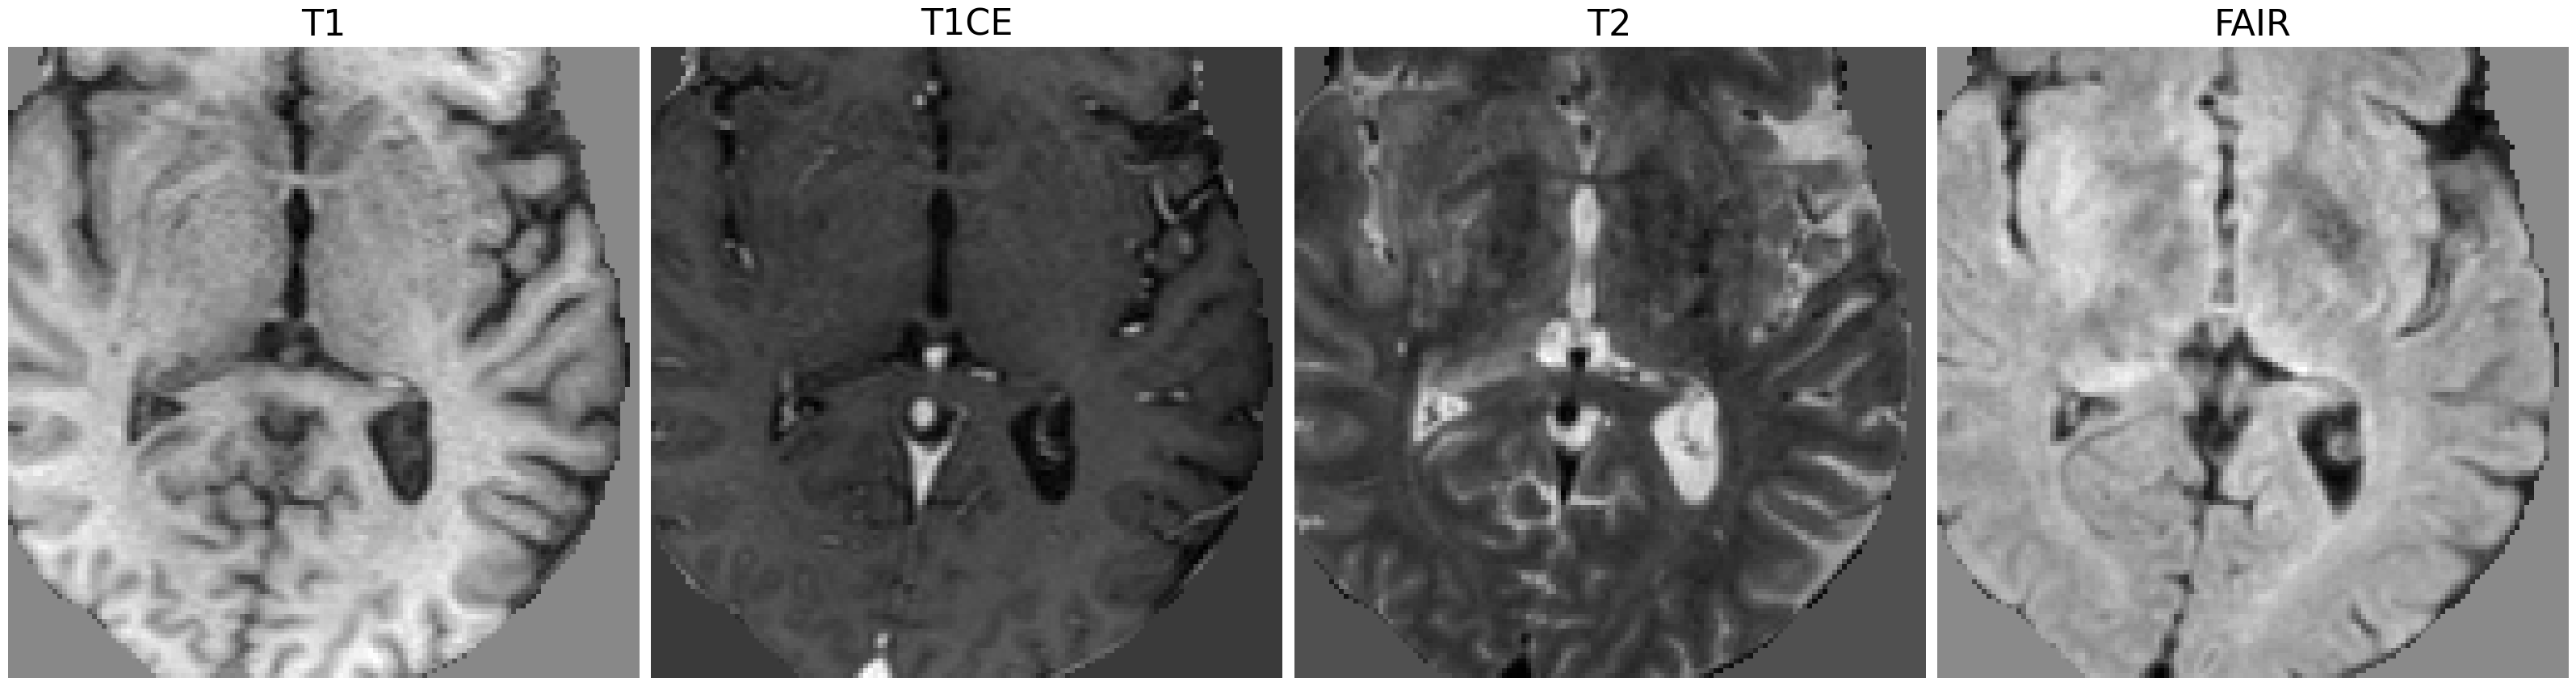

In [19]:
fig,axs = plt.subplots(1, 4,figsize=(32,9), dpi= 100, facecolor='w', edgecolor='k')
for i, modality,ax in zip(range(4),['T1','T1CE','T2','FAIR'],axs):
    ax.imshow(image[0,i,60,:,:],cmap='gray')
    ax.axis('off')
    ax.set_title(modality, y=1.0, pad=10,fontsize=32)
plt.tight_layout()
plt.show()


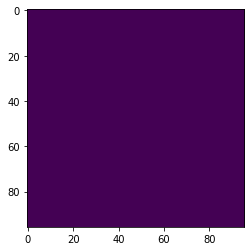

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
# label demo
plt.imshow(target[60,:,:])
plt.show()
target[60,:,:]

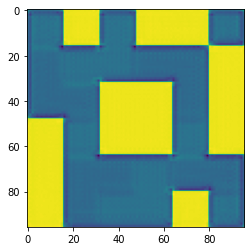

array([[-3.86523438, -4.1875    , -4.44921875, ..., -4.2421875 ,
        -3.859375  , -3.1328125 ],
       [-4.1484375 , -4.96484375, -4.4375    , ..., -5.21875   ,
        -5.15625   , -4.375     ],
       [-4.7421875 , -5.2578125 , -4.54296875, ..., -4.765625  ,
        -5.015625  , -4.38671875],
       ...,
       [-1.06542969, -1.15039062, -1.15820312, ..., -4.76953125,
        -4.82421875, -4.44921875],
       [-1.0546875 , -1.07617188, -1.12304688, ..., -4.78125   ,
        -5.33984375, -4.21484375],
       [-1.2109375 , -1.01953125, -1.0625    , ..., -4.828125  ,
        -4.74609375, -3.76757812]])

In [14]:
# flip demo
plt.imshow(flip[60,:,:])
plt.show()
flip[60,:,:]

(2, 4, 128, 128, 128)


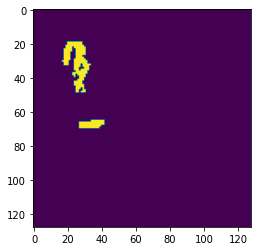

In [22]:
shape = target.shape
out = np.zeros([shape[0], 4, shape[2], shape[3], shape[4]])
target_4d = np.squeeze(target)
for i in range(4):
    out[:, i, :, :, :] =(target_4d == i)
print(out.shape)
plt.imshow(out[0,1,60,:,:])
plt.show()

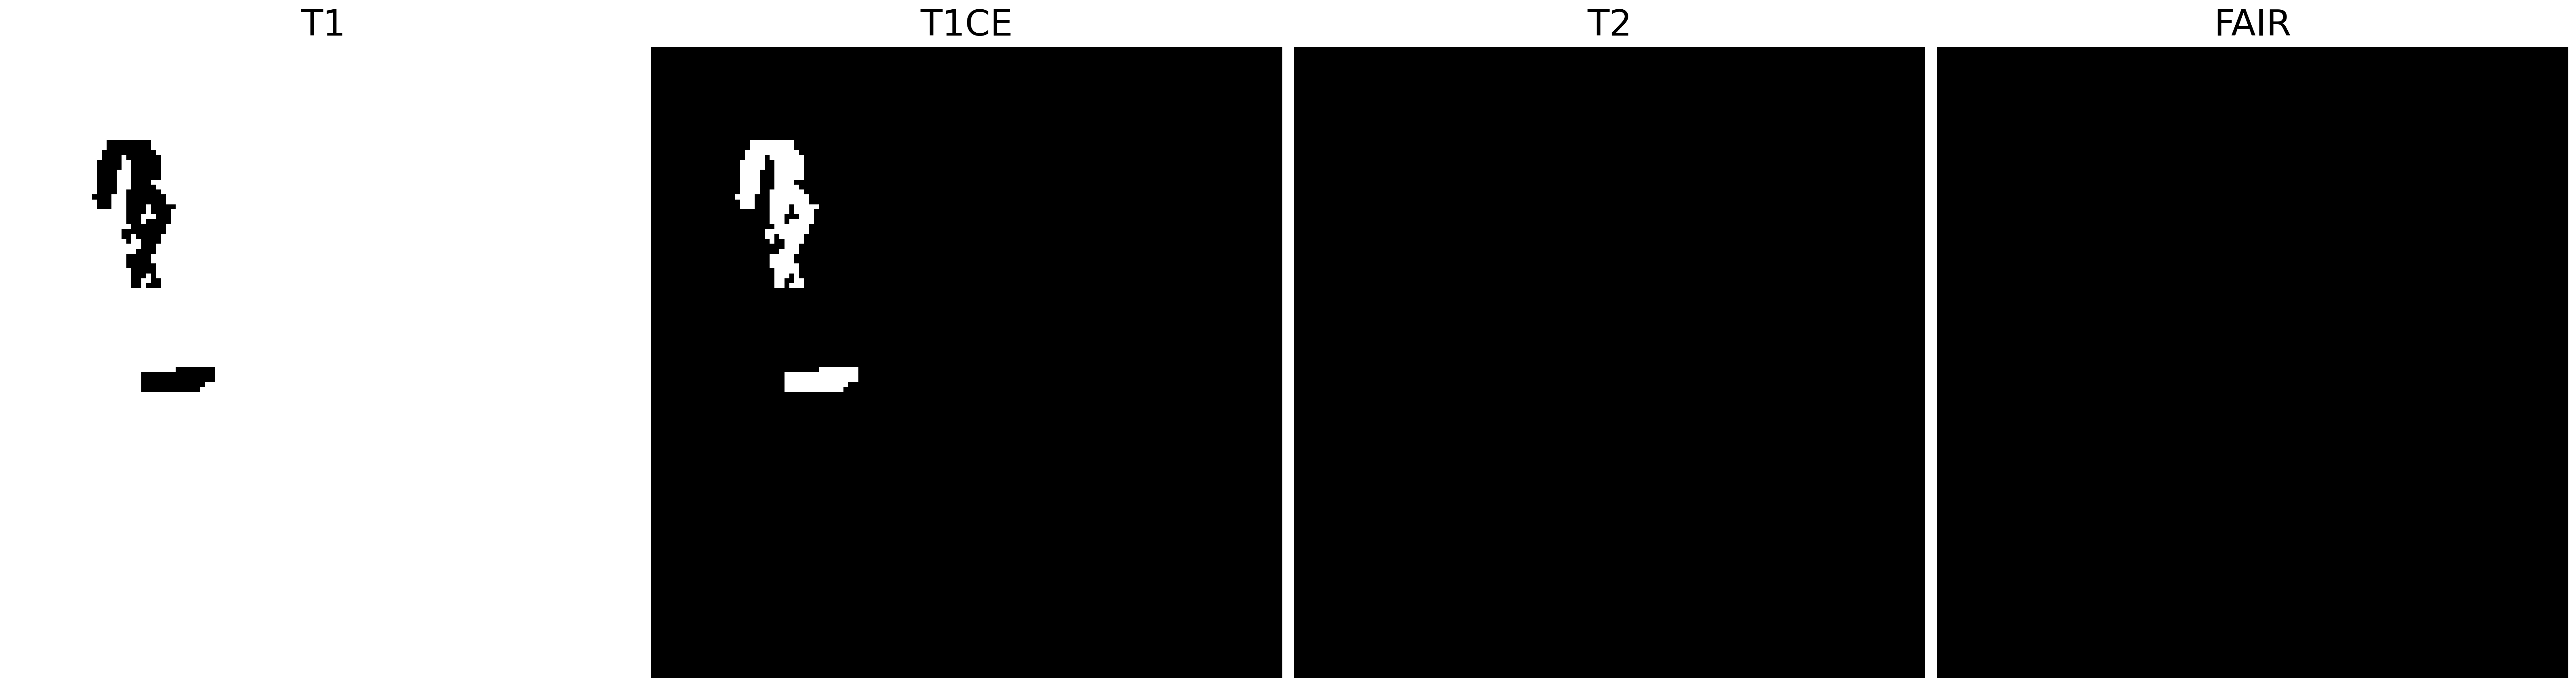

In [23]:
def to_binary_np(target):
    shape = target.shape
    out = np.zeros([shape[0], 4, shape[2], shape[3], shape[4]])
    target_4d = np.squeeze(target)
    for i in range(4):
        out[:, i, :, :, :] =(target_4d == i)
    return out
# 0(background), 1(edma), 2(non-enhancing tumor), 3(enchancing tumor)¶
target_binary = to_binary_np(target)
fig1,axs = plt.subplots(1, 4,figsize=(32,9), dpi= 200, facecolor='w', edgecolor='k')
for i, label_type,ax in zip(range(4),['T1','T1CE','T2','FAIR'],axs):
    ax.imshow(target_binary[0,i,60,:,:],cmap='gray')
    ax.axis('off')
    ax.set_title(label_type, y=1.0, pad=10,fontsize=32)
plt.tight_layout()
plt.show()

In [24]:
flip_matrix = torch.from_numpy(flip)
target = torch.from_numpy(target)

In [25]:
def softmax_helper(x):
    rpt = [1 for _ in range(len(x.size()))]
    rpt[1] = x.size(1)
    x_max = x.max(1, keepdim=True)[0].repeat(*rpt)
    e_x = torch.exp(x - x_max)
    return e_x / e_x.sum(1, keepdim=True).repeat(*rpt)
def to_binary(y):
        shape = y.shape
        #c = int(torch.max(y).item() + 1)
        out = torch.zeros([shape[0], 4, shape[2], shape[3], shape[4]]).to(y.device.index)
        for i in range(4):
            out[:, i:i + 1, :, :, :] = (y == i)
        return out

import torch
label = to_binary(target)
label2 = softmax_helper(torch.tanh(flip_matrix).float() + label)
label2 = label2.argmax(1)
label2 = torch.unsqueeze(label2, 1)
label2 = to_binary(label2)

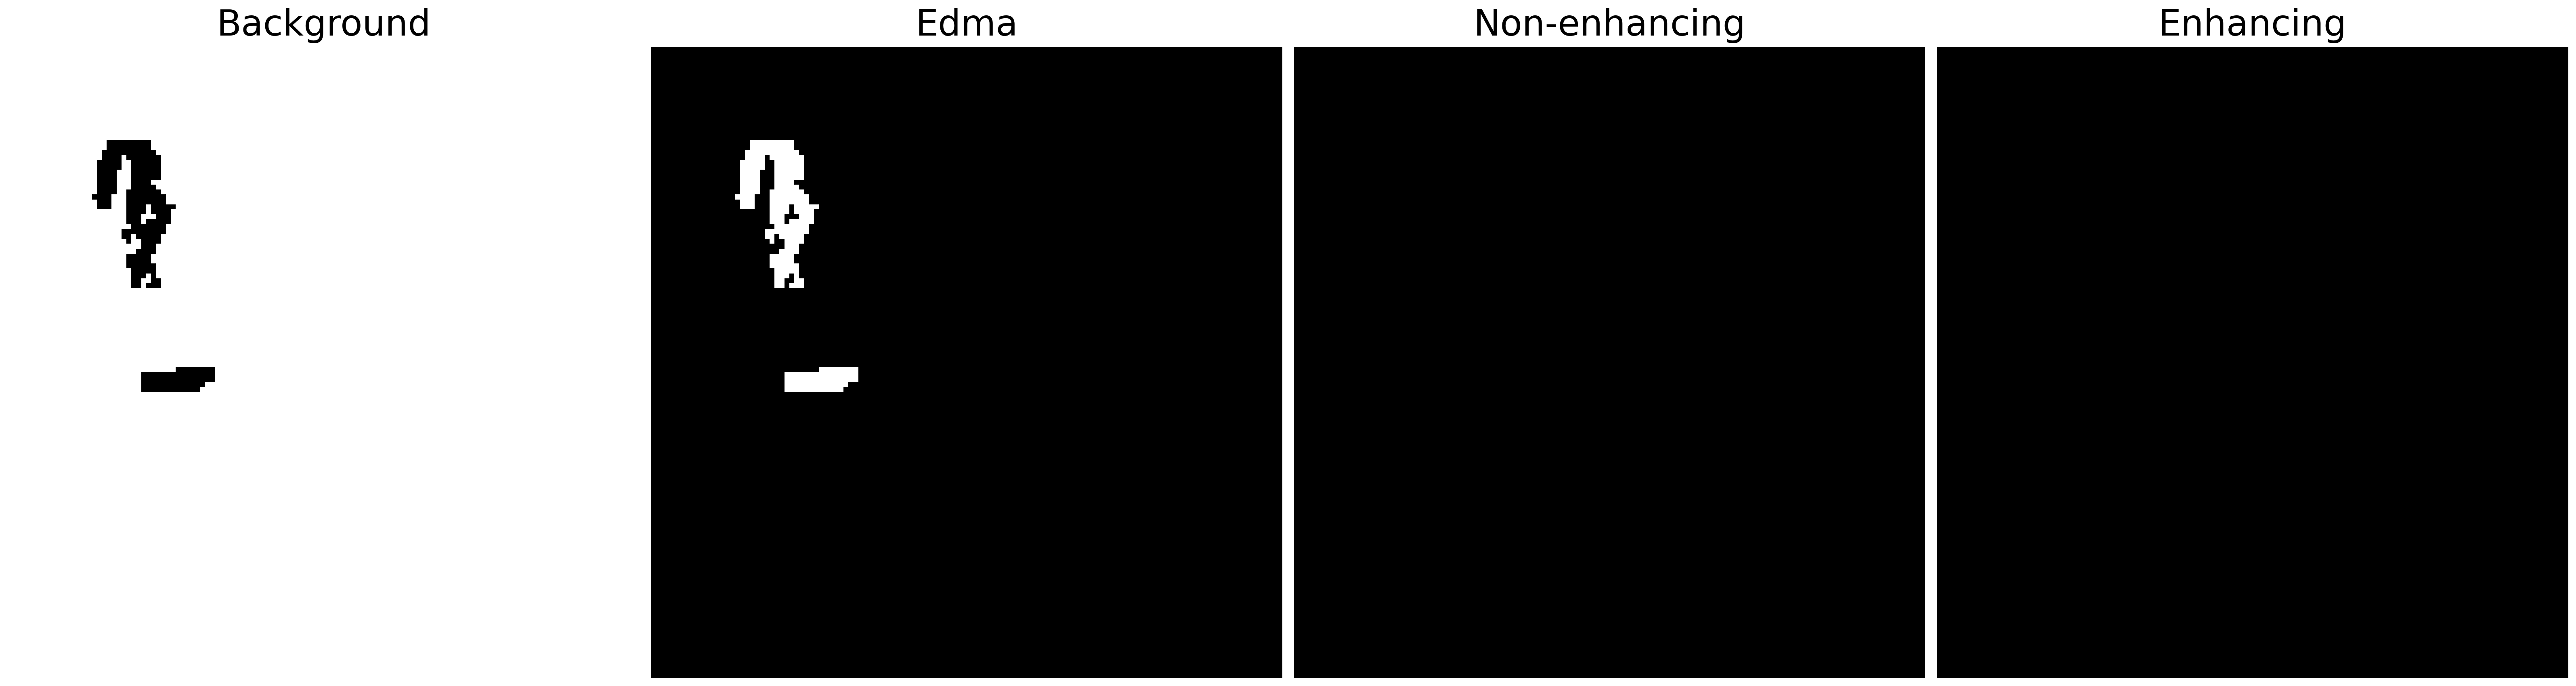

In [26]:
fig2,axs = plt.subplots(1, 4,figsize=(32,9), dpi= 200, facecolor='w', edgecolor='k')
for i, label_type,ax in zip(range(4),['Background','Edma','Non-enhancing','Enhancing'],axs):
    ax.imshow(label[0,i,60,:,:],cmap='gray')
    ax.axis('off')
    ax.set_title(label_type, y=1.0, pad=10,fontsize=32)
plt.tight_layout()
plt.show()

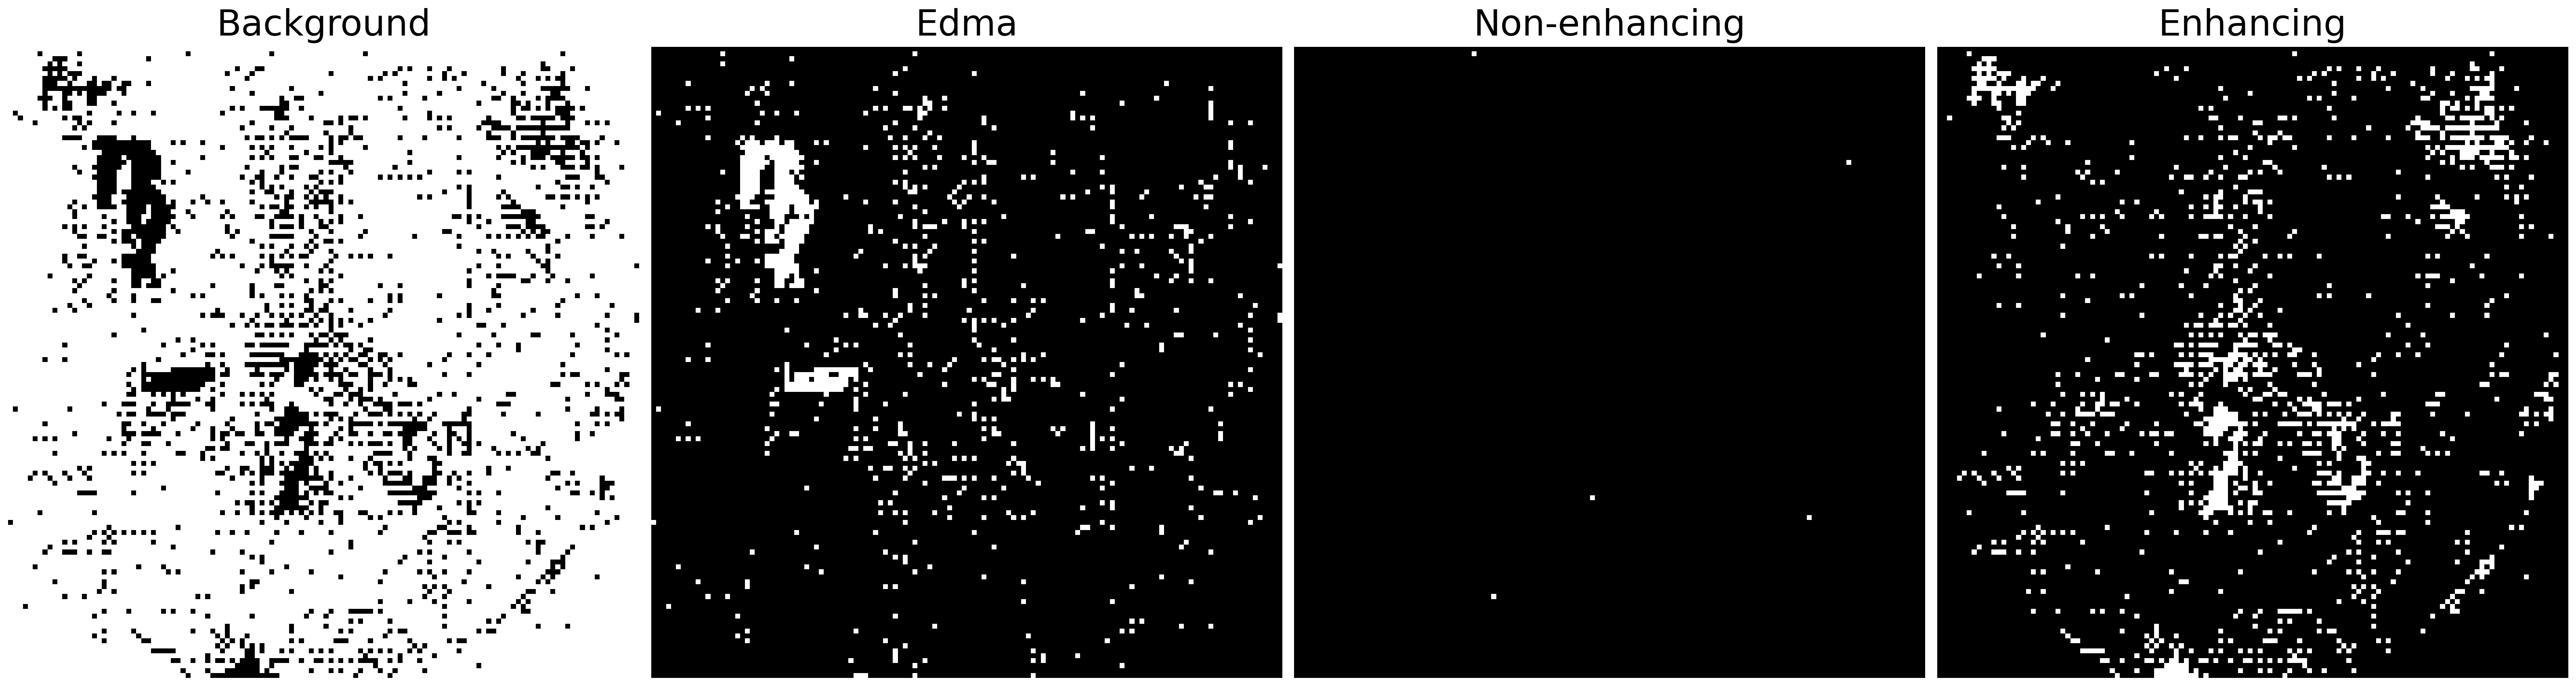

In [27]:
fig2,axs = plt.subplots(1, 4,figsize=(32,9), dpi= 200, facecolor='w', edgecolor='k')
for i, label_type,ax in zip(range(4),['Background','Edma','Non-enhancing','Enhancing'],axs):
    ax.imshow(label2[0,i,60,:,:],cmap='gray')
    ax.axis('off')
    ax.set_title(label_type, y=1.0, pad=10,fontsize=32)
plt.tight_layout()
plt.show()